## Ranking Reviews

To some degree we follow the logic here: https://nbviewer.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter4_TheGreatestTheoremNeverTold/Ch4_LawOfLargeNumbers_PyMC2.ipynb

However this is a problem I've encountered often before. People try to sort or rank or order things based on some score, when that score is created from different samples sizes for different entities, leading to "pathological ordering" as described in the notebook. I'll add my own extension on how to consider sorting these cases rationally.

In [1]:
import numpy as np
np.random.seed(42)

### generate scores


suppose we have k products, each with n_i reviews ranging from 1 to 5 stars. source the reviews from different multinomial distributions with randomly set params. we can use a dirichlet distribution (stick-breaking) to generate valid values for these 5-outcome probabilities. 

Dirichlet distributions are very cool! More on understanding how their params work: https://builtin.com/data-science/dirichlet-distribution

In [2]:
test_dirichlets = np.random.dirichlet(alpha=[3,3,6,6,4], size=3)
test_dirichlets

array([[0.14930397, 0.10255247, 0.21486729, 0.21486882, 0.31840746],
       [0.2012259 , 0.09612238, 0.34422275, 0.30538451, 0.05304446],
       [0.05960729, 0.14390011, 0.44425147, 0.23044177, 0.12179936]])

In [5]:
k = 10
n_reviews = np.random.randint(low = 1, high=100, size=k)
true_product_distributions = np.random.dirichlet(alpha=[3,3,6,6,4], size=k) # generate the true distributions for product

reviews_arraylist = []
for i in range(0, k):
    reviews_by_stars = np.random.multinomial(n_reviews[i], true_product_distributions[i]) # generate reviews based on review distribution
    reviews_arraylist.append(reviews_by_stars)


reviews_array = np.array(reviews_arraylist)

In [8]:
reviews_array # number of 1, 2, 3, 4, and 5 star reviews for each product; sum of these reviews correspond to n_reviews[i]

array([[ 0,  2, 10,  9,  0],
       [ 2, 15, 22, 25,  9],
       [ 4,  8, 11, 10,  6],
       [ 2,  2,  7,  6,  1],
       [ 0,  0,  1,  3,  0],
       [15,  5, 16, 44,  9],
       [ 8,  9, 14, 17, 12],
       [ 1,  3,  2,  6,  2],
       [ 1,  4,  3,  1,  0],
       [ 8, 22, 34, 23,  3]])

In [9]:
reviews_array.sum(axis=1) # needs to match n_reviews

array([21, 73, 39, 18,  4, 89, 60, 14,  9, 90])

In [10]:
n_reviews # matches!

array([21, 73, 39, 18,  4, 89, 60, 14,  9, 90])

### modeling approach

If we were modeling binomial outcomes, we could use the beta-binomial model and skip pymc altogether, because the posterior beta distribution is super easy to generate from the prior and the binomial outcomes. take the number of heads, and it to the first param, take the number of tails, add it to the second param, done.

Is as simple a closed form possible for multinomials, with say dirichlet priors, as a generalization of the beta-binomial model? I'm actually not sure. But we can definitely solve this in pymc. And since we've already reasoned out a good data generating process for simulating this data, we can use it as the model going the other way too. 

More docs: https://www.pymc.io/projects/docs/en/v3/pymc-examples/examples/mixture_models/dirichlet_mixture_of_multinomials.html

In [11]:
import pymc as pm


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [14]:
with pm.Model() as model:
    
    dirichlet = pm.Dirichlet("dirichlet",(5,5,5,5,5), shape=reviews_array.shape)
    obs = pm.Multinomial("obs",n_reviews, dirichlet, observed=reviews_array)

    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(12000, step=step, initvals=start)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [dirichlet]


Sampling 4 chains for 1_000 tune and 12_000 draw iterations (4_000 + 48_000 draws total) took 19 seconds.


In [15]:
model.basic_RVs

[dirichlet, obs]

In [16]:
n_reviews

array([21, 73, 39, 18,  4, 89, 60, 14,  9, 90])

first order sanity check: how close are the posterior means are relative to n_reviews?

In [102]:
trace.posterior.dirichlet.mean(axis=(0,1))

<xarray.DataArray 'dirichlet' (dirichlet_dim_0: 10, dirichlet_dim_1: 5)>
array([[0.10828038, 0.15315167, 0.326033  , 0.3034048 , 0.10913015],
       [0.07147889, 0.20559513, 0.27477687, 0.30516349, 0.14298562],
       [0.1406128 , 0.20362662, 0.25048312, 0.233518  , 0.17175946],
       [0.16200792, 0.16269855, 0.28106328, 0.25528442, 0.13894583],
       [0.17254412, 0.17259326, 0.20597164, 0.27660298, 0.17228801],
       [0.17625399, 0.08742495, 0.18426553, 0.42945467, 0.12260086],
       [0.15198584, 0.16529536, 0.22342446, 0.25960099, 0.19969335],
       [0.15379199, 0.20492479, 0.18007178, 0.28199606, 0.17921538],
       [0.17660621, 0.26521878, 0.23494614, 0.17623012, 0.14699874],
       [0.11232049, 0.23572996, 0.33851109, 0.2439948 , 0.06944365]])
Coordinates:
  * dirichlet_dim_0  (dirichlet_dim_0) int64 0 1 2 3 4 5 6 7 8 9
  * dirichlet_dim_1  (dirichlet_dim_1) int64 0 1 2 3 4

In [104]:
true_product_distributions

array([[0.11131801, 0.07025165, 0.44178848, 0.30675216, 0.06988971],
       [0.04875374, 0.1416972 , 0.35941448, 0.28726637, 0.16286821],
       [0.09924754, 0.08927091, 0.38599335, 0.29143884, 0.13404936],
       [0.06977753, 0.15515045, 0.34714987, 0.3345966 , 0.09332554],
       [0.09083606, 0.08111399, 0.21689144, 0.32430687, 0.28685164],
       [0.13350483, 0.07058896, 0.22568907, 0.4151209 , 0.15509625],
       [0.12380991, 0.13032705, 0.36790919, 0.22162839, 0.15632546],
       [0.18287302, 0.13291642, 0.24205073, 0.34043479, 0.10172504],
       [0.1238225 , 0.18174277, 0.36068524, 0.16694105, 0.16680844],
       [0.12917858, 0.18115982, 0.33754014, 0.29411158, 0.05800989]])

### Plot the posterior distributions against the true values for different products

Below I wrote a helper class that plots out, for a given product, what the true values (the generative multinomial) versus what our posterior values are for each param in the multinomial (there are 5 here per product)

In [95]:
class plot_posterior:

    def __init__(self, trace_obj, true_dist, num_reviews):
        self.trace_obj = trace_obj
        self.true_dist = true_dist
        self.num_reviews = num_reviews
        self.gen_posterior_stats()

    def gen_posterior_stats(self, uq=0.95, lq=0.05):
        self.post_mean = self.trace_obj.posterior.dirichlet.mean(axis=(0,1))
        #self.post_uq = np.quantile(self.trace_obj.posterior.dirichlet.to_numpy, uq, axis=(0,1))
        #self.post_lq = np.quantile(self.trace_obj.posterior.dirichlet.to_numpy, lq, axis=(0,1))

    def plot_jth_posterior(self, j):
        colors = ['red','blue','green','orange','purple']
        plt.figure(figsize=(10,5))
        for i in range(0,5):
            plt.hist(self.trace_obj.posterior.dirichlet[:,:,j,i].to_numpy().flatten(), alpha=0.3, color=colors[i])
            plt.axvline(self.true_dist[j,i], color=colors[i], label=str(i+1)+" star")
            plt.axvline(self.post_mean[j,i], color=colors[i], linestyle='--', alpha=0.3)
            plt.title("posterior multinomial plus truth for number "+ str(j)+" product with " + str(self.num_reviews[j]) + " reviews")
            plt.legend()    
    
    

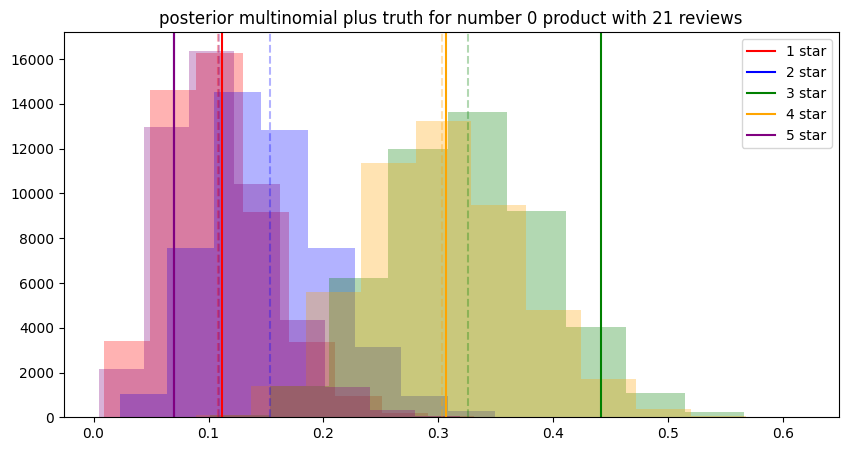

In [100]:
plot_obj = plot_posterior(trace, true_product_distributions, n_reviews)
plot_obj.plot_jth_posterior(0)

At N=21 reviews we don't do terribly but our estimate for the percentage of 3 star reviews is way, way off. Probably because we set a relatively strong prior and the data havent been sufficient to move it. 

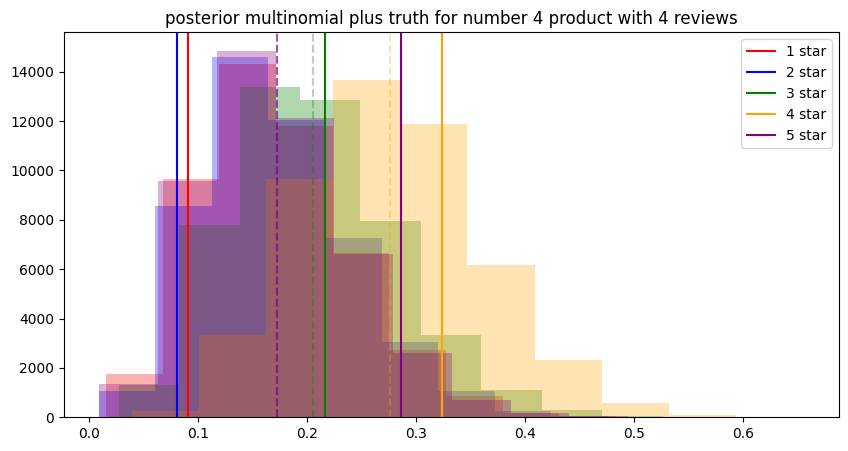

In [101]:
plot_obj = plot_posterior(trace, true_product_distributions, n_reviews)
plot_obj.plot_jth_posterior(4)

At N=4 it's a similar story but worse. We may as well have just used our priors.

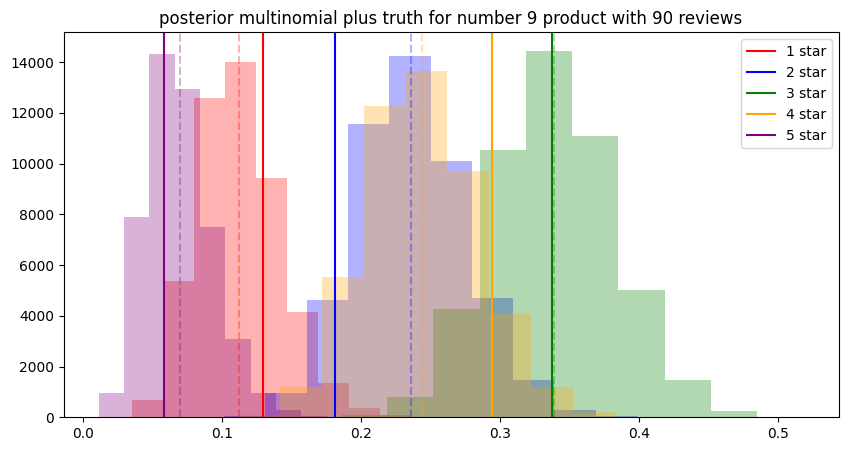

In [97]:
plot_obj.plot_jth_posterior(9)

This case is interesting; we have 90 reviews, and overall we seem to be doing pretty well, except our estimation of the true fraction of 2 and 4 star reviews doesn't look great. For 4 star reviews we understimate, and for 2 star reviews we overestimate. Still, it does look like our distributions cover the true values, so that's good! But if we were to ask the question "what is the difference between the number of 2 star and 4 star reviews" from the distributions themselves it looks like our posterior would say "no real difference" whereas there's clearly a significant difference in reality. However, the distributions don't tell the whole story. If there's an anticorrelation in our pairs of 2-star and 4-star values such that a lower 2-star value is usually paired with a higher 4-star value and vice versa, the distribution of differences might still be quite far from centered at 0 even though the actual distributions largely overlap. 

### Weaker Prior

What happens when we do the same thing but with a weaker prior? Is a dirichlet(0,0,0,0,0) weaker?

In [106]:
with pm.Model() as model:
    
    dirichlet = pm.Dirichlet("dirichlet",(0.001,0.001,0.001,0.001,0.001), shape=reviews_array.shape)
    obs = pm.Multinomial("obs",n_reviews, dirichlet, observed=reviews_array)

    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(12000, step=step, initvals=start)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [dirichlet]


Sampling 4 chains for 1_000 tune and 12_000 draw iterations (4_000 + 48_000 draws total) took 19 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


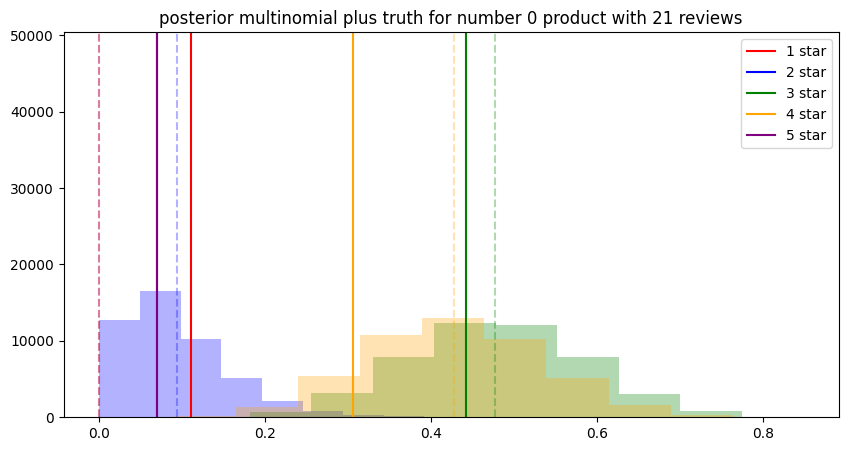

In [107]:
plot_obj = plot_posterior(trace, true_product_distributions, n_reviews)
plot_obj.plot_jth_posterior(0)

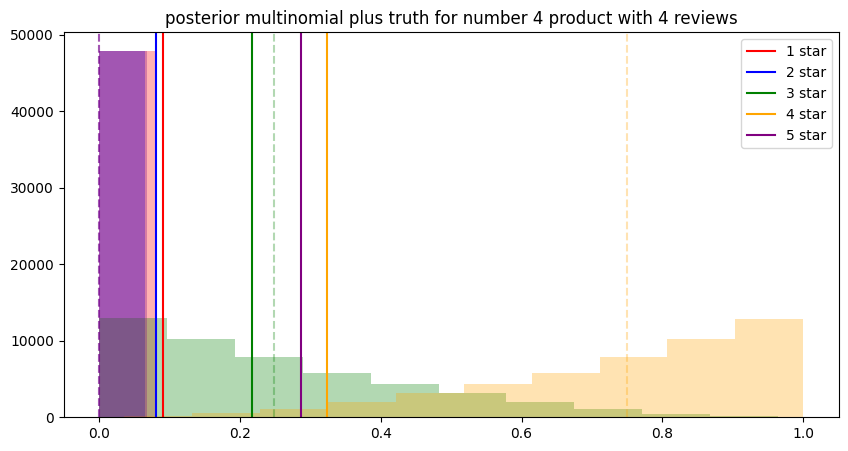

In [108]:
plot_obj = plot_posterior(trace, true_product_distributions, n_reviews)
plot_obj.plot_jth_posterior(4)

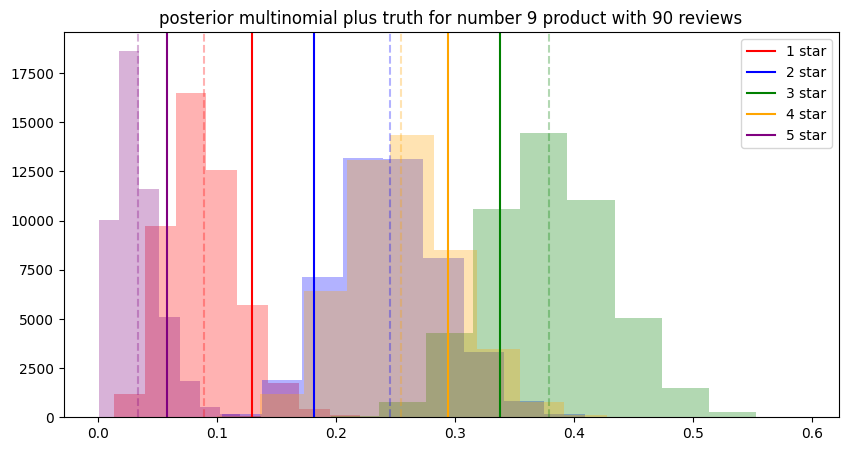

In [109]:
plot_obj.plot_jth_posterior(9)